In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

/Users/kevin/code/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Users/kevin/code/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Users/kevin/code/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)
/Users/kevin/code/anaconda3/

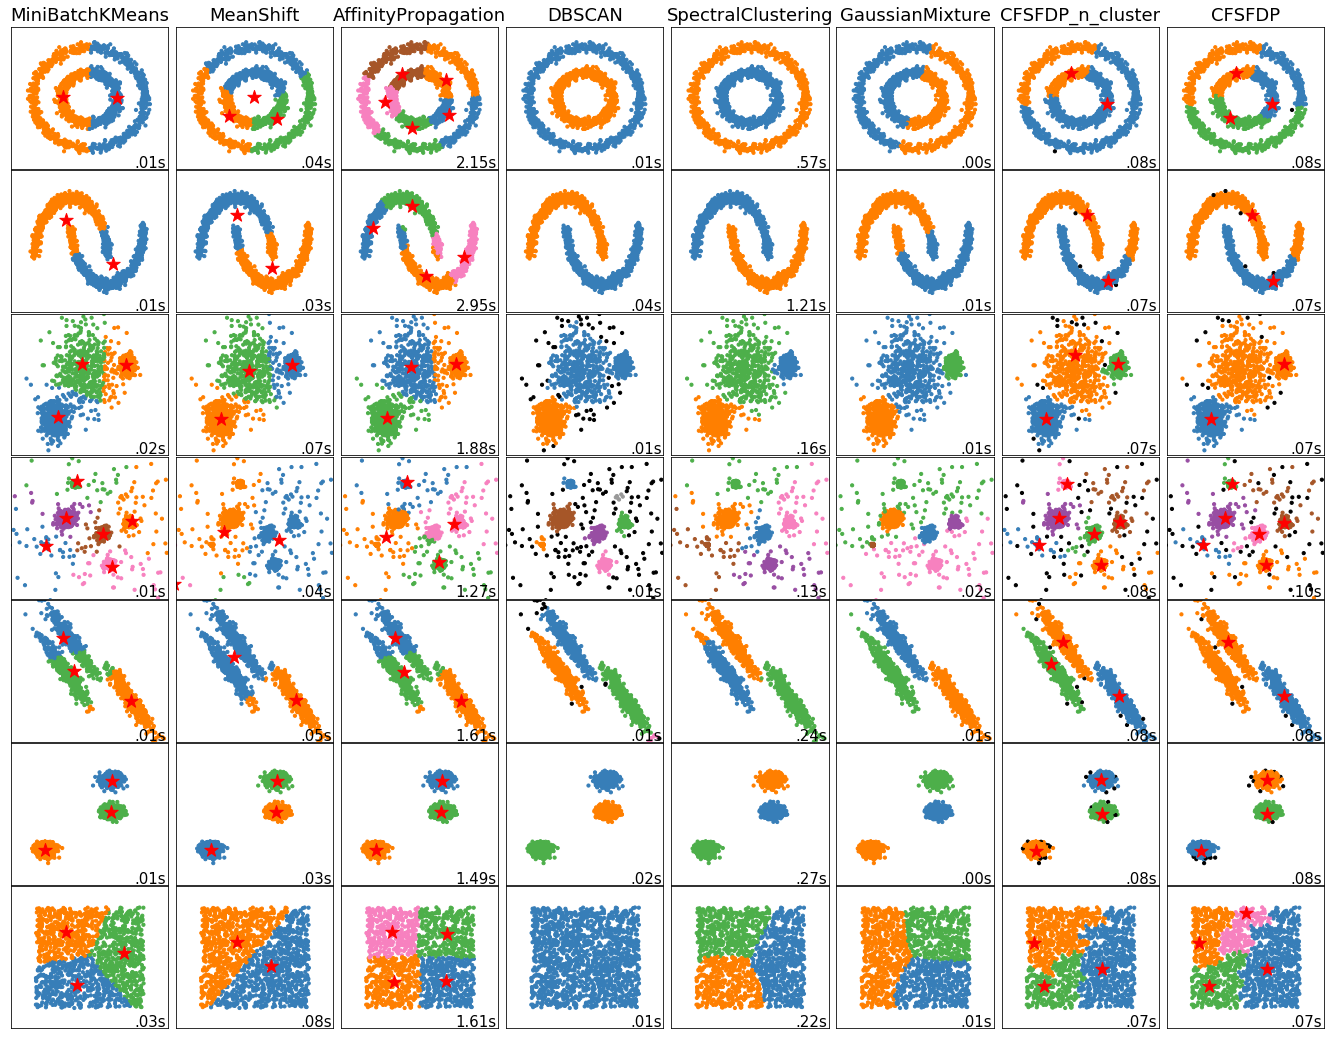

In [2]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

from CFSFDP import CFSFDP

np.random.seed(10)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
varied_large = datasets.make_blobs(n_samples=n_samples,
                                   centers=7,
                                   cluster_std=[0.1, 1.0, 10.5, 0.5, 0.5, 0.7, 0.3],
                                   random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(8 * 2 + 3, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (varied_large, {'eps': .18, 'n_neighbors': 2, 'n_clusters': 6}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('MeanShift', ms),
        ('AffinityPropagation', affinity_propagation),
        ('DBSCAN', dbscan),
        ('SpectralClustering', spectral),
        ('GaussianMixture', gmm),
        ('CFSFDP_n_cluster', CFSFDP(n_clusters=params['n_clusters'])),
        ('CFSFDP', CFSFDP()),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        if hasattr(algorithm, 'cluster_centers_'):
            c = algorithm.cluster_centers_
            plt.scatter(c[:, 0], c[:, 1], s=200, marker='*', color='red')

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1
                
plt.savefig('./cluster_results.pdf')

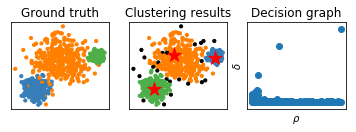

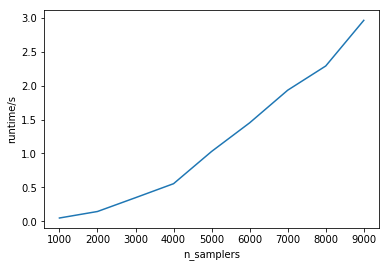

In [3]:
from sklearn import cluster, datasets, mixture
from CFSFDP import CFSFDP

np.random.seed(10)
random_state = 170
plt.figure(figsize=(3 * 2, 3.5))

plt_num = 1

ts = []
xs = np.arange(1000, 10000, 1000)
for i, n_samples in enumerate(xs):
    (X, y) = datasets.make_blobs(n_samples=n_samples,
                                 cluster_std=[1.0, 2.5, 0.5],
                                 random_state=random_state)
    t = time.time()
    algorithm = CFSFDP(n_clusters=3).fit(X)
    y_pred = algorithm.labels_
    c = algorithm.cluster_centers_
    ts.append(time.time() - t)
    
    if n_samples in [1000]:
        plt.subplot(2, 3, plt_num)
        plt_num += 1
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])
        plt.xticks(())
        plt.yticks(())
        plt.title('Ground truth')

        plt.subplot(2, 3, plt_num)
        plt_num += 1
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        plt.scatter(c[:, 0], c[:, 1], s=200, marker='*', color='red')
        plt.xticks(())
        plt.yticks(())
        plt.title('Clustering results')

        plt.subplot(2, 3, plt_num)
        plt_num += 1
        plt.scatter(algorithm.rho, algorithm.delta)
        plt.xticks(())
        plt.yticks(())
        plt.xlabel(r'$\rho$')
        plt.ylabel(r'$\delta$')
        plt.title('Decision graph')
plt.show()
# plt.savefig('./basic.pdf')

plt.figure()
plt.plot(xs, ts)
plt.xlabel('n_samplers')
plt.ylabel('runtime/s')
# plt.savefig('./runtime.pdf')
plt.show()